# Spider Movement Analysis using PCA

# Part 3: Leg Agnostic PCA

## Introduction

This notebook analyses how spiders move by looking at 3D recordings of their body positions. We use a technique called Principal Component Analysis (PCA) to break down complex spider movements into simpler, fundamental motion patterns. This helps us understand how spiders coordinate their legs and body during different behaviours.

Here we will treat the legs agnostically. This means the PCA will find patterns in the leg motion that are independent of leg identity. While the spider no doubtedly coordinates its legs, this analysis is about finding the controls of each leg. Comparing the scores for each leg will then give some idea of how they are used differently. 

Treating the legs agnostically has an advantage over the full shape PCA. There will be a higer number of rows to columns (as there is now just coxa, patella, tibia-metatarsal, and claw, not claws 1-8 etc). The effect of measurement error will now be much smaller. We can find the coordinations across legs by looking at the scores, but this leg agnostic model could also be the first step to remove spurious datapoints. 

The main challenge is rotating the legs to the same position. We cannot use a "leg vector" from the base of the leg to some point on the leg because this would remove the rotational freedom of the leg that is controlled by the spider. For example, if we measure a vector from the base of the leg (coxa) to the patella (first joint), for every leg position this will remove the actual rotation of the leg at this joint. The same for coxa to claw or anything else on the leg. 

Instead I have just reflected the left side of the spider to the right to copy the bilateral symmetry of the spider. Then I am going to test whether a leg-agnostic PCA with reflection can find the leg-direction as a component. 

We can then carry on to look at how the scores differ across legs, experimental conditions, and over time. 


<img src="./images/spider_defs.png" alt="Spider" style="width: 60%;">

## Table of Contents


1. **Introduction**
   - Overview of leg agnostic PCA approach
   - Advantages and challenges 
   - Methodology for leg rotation and reflection

2. **Setup and Data Loading**
   - Library imports
   - Loading processed data

3. **Data Processing**
   - Getting all legs data
   - Reflecting left side to match right
   - Making coxa the origin
   - Plotting leg overlay

4. **Leg Agnostic PCA**
   - Running PCA
   - Explained variance analysis
   - Component animation

5. **Score Analysis**
   - Scores for each leg
   - PC1 analysis (leg direction)
   - PC2 analysis (leg spread)
   - Score storage in dataframe

6. **Experimental Conditions Analysis**
   - PC1 analysis by condition
   - PC2 analysis by condition
   - PC3 analysis by condition

7. **Temporal Analysis**
   - Score analysis over time
   - PC1 temporal patterns
   - Multiple PC temporal patterns
   - Component comparison by leg

## Setup and Data Loading

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from pathlib import Path

from morphing_birds import Spider3D, animate_plotly, animate
from spiderpca import (
    get_all_legs_markers, make_coxa_origin,
    reflect_legs, restore_leg_positions,
    plot_leg_overlay,
    run_PCA, plot_explained, get_score_range, reconstruct, 
    create_scores_dataframe, 
    plot_pc_histogram, plot_leg_score_hist, plot_leg_score_hist_panelled,
    plot_leg_pc_timeseries
)

### Data Loading

We will use the processed data from the first notebook. Whole body pitch has been removed. 

In [3]:
marker_data = np.load(Path("../data/processed/carolina_no_pitch_marker_data.npy"))
marker_columns = np.load(Path("../data/processed/carolina_marker_columns.npy"))
carolina_info = pd.read_csv(Path("../data/processed/carolina_info.csv"))

# Check the dimensions of the data
assert marker_data.shape[1]*marker_data.shape[2] == len(marker_columns), "Number of columns in marker data and marker columns do not match"
assert marker_data.shape[0] == carolina_info.shape[0], "Number of rows in marker data and info dataframe do not match"

print(marker_data.shape)
print(str(marker_columns))

(20567, 35, 3)
['claw1_x' 'claw1_y' 'claw1_z' 'tibiametatarsus1_x' 'tibiametatarsus1_y'
 'tibiametatarsus1_z' 'patella1_x' 'patella1_y' 'patella1_z' 'coxa1_x'
 'coxa1_y' 'coxa1_z' 'claw2_x' 'claw2_y' 'claw2_z' 'tibiametatarsus2_x'
 'tibiametatarsus2_y' 'tibiametatarsus2_z' 'patella2_x' 'patella2_y'
 'patella2_z' 'coxa2_x' 'coxa2_y' 'coxa2_z' 'claw3_x' 'claw3_y' 'claw3_z'
 'tibiametatarsus3_x' 'tibiametatarsus3_y' 'tibiametatarsus3_z'
 'patella3_x' 'patella3_y' 'patella3_z' 'coxa3_x' 'coxa3_y' 'coxa3_z'
 'claw4_x' 'claw4_y' 'claw4_z' 'tibiametatarsus4_x' 'tibiametatarsus4_y'
 'tibiametatarsus4_z' 'patella4_x' 'patella4_y' 'patella4_z' 'coxa4_x'
 'coxa4_y' 'coxa4_z' 'claw5_x' 'claw5_y' 'claw5_z' 'tibiametatarsus5_x'
 'tibiametatarsus5_y' 'tibiametatarsus5_z' 'patella5_x' 'patella5_y'
 'patella5_z' 'coxa5_x' 'coxa5_y' 'coxa5_z' 'claw6_x' 'claw6_y' 'claw6_z'
 'tibiametatarsus6_x' 'tibiametatarsus6_y' 'tibiametatarsus6_z'
 'patella6_x' 'patella6_y' 'patella6_z' 'coxa6_x' 'coxa6_y' 'coxa6_z'

## Get All Legs

First, we load our reference spider shape data using the `Spider3D` class. This defines the order of the markers in the spider shape which we use for plotting. 

We will then reorder the data to be leg agnostic:

- `[nFrames, nLegs, nKeypoints, nDims] = (20567, 8, 4, 3)`



In [4]:
spider3d = Spider3D(Path("../data/mean_spider_shape_carolina.csv"))

num_legs = 8
all_legs, all_legs_names, markers_again = get_all_legs_markers(spider3d.marker_names, marker_data, num_legs)
assert np.allclose(markers_again, marker_data), "Markers do not match the original markers!"
print(all_legs_names)

# check_markers = put_legs_back(all_legs, all_legs_names, spider3d.marker_names, marker_data)
# assert np.allclose(check_markers, marker_data), "Markers do not match the original markers!"



All legs shape: (20567, 8, 4, 3)
Frames: 20567, Legs: 8, Keypoints: 4, Dims: 3
[['claw1', 'tibiametatarsus1', 'patella1', 'coxa1'], ['claw2', 'tibiametatarsus2', 'patella2', 'coxa2'], ['claw3', 'tibiametatarsus3', 'patella3', 'coxa3'], ['claw4', 'tibiametatarsus4', 'patella4', 'coxa4'], ['claw5', 'tibiametatarsus5', 'patella5', 'coxa5'], ['claw6', 'tibiametatarsus6', 'patella6', 'coxa6'], ['claw7', 'tibiametatarsus7', 'patella7', 'coxa7'], ['claw8', 'tibiametatarsus8', 'patella8', 'coxa8']]


## Reflect the Left Side to Match the Right

In [5]:
reflected_legs = reflect_legs(all_legs)
print(reflected_legs.shape)



(20567, 8, 4, 3)


## Make the Coxa the origin

We are just running PCA on the legs, so we can make each coxa the origin. The coxa is the last keypoint for each leg. 



In [6]:
new_legs, coxa_positions = make_coxa_origin(reflected_legs)
print(new_legs.shape)



(20567, 8, 4, 3)


### Plot the legs

Now we have given the legs their own origin, and reflected the left side, we can plot a random 100 frames to see how this looks. The lighter colour should be overlaid with the darker colour, as these represent the leg pairs. 

We have not rotated the legs further, so we can still see the front legs pointing forwards and the rear legs pointing backwards, etc. 

In [7]:
fig = plot_leg_overlay(new_legs)
fig.show()

## Leg Agnostic PCA

We can now run PCA where we treat the legs agnostically. This means PCA is looking for how the spider moves each leg (as though it only has one leg in each frame). This will make the number of frames much higher, and the number of markers much lower. It will be less sensitive to measurement error. The PCA is now not looking for coordination between legs, but rather how the spider moves each leg. We can look for coordination from the scores.  

As a test we can see whether the first component from the PCA is the leg direction. 


In [8]:
print(f"All legs shape: {new_legs.shape}")

nFrames = new_legs.shape[0]
nLegs = new_legs.shape[1]
nMarkers = new_legs.shape[2]
nDims = new_legs.shape[3]

anon_legs = new_legs.reshape(-1, nMarkers, nDims)

print(f"Leg Agnostic shape: {anon_legs.shape}")

principal_components, scores, pca = run_PCA(anon_legs)


mu = np.mean(anon_legs, axis=0).reshape(1, -1, 3)

print(f"Number of frames: {nFrames}")
print(f"Number of markers: {nMarkers}")
print(f"Principal components: {principal_components.shape}")
print(f"Scores: {scores.shape}")
# print(f"Explained variance: {np.cumsum(pca.explained_variance_ratio_)}")
print(f"mu: {mu.shape}")

above_90 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0]
above_95 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]
above_99 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]
print(f"{above_90} components needed to explain 90% of the variance.")
print(f"{above_95} components needed to explain 95% of the variance.")
print(f"{above_99} components needed to explain 99% of the variance.")

# Reshape scores into (nFrames, nLegs, nPCs)
reshaped_scores = scores.reshape(nFrames, nLegs, principal_components.shape[0])
print(reshaped_scores.shape)


All legs shape: (20567, 8, 4, 3)
Leg Agnostic shape: (164536, 4, 3)
Number of frames: 20567
Number of markers: 4
Principal components: (12, 12)
Scores: (164536, 12)
mu: (1, 4, 3)
1 components needed to explain 90% of the variance.
2 components needed to explain 95% of the variance.
4 components needed to explain 99% of the variance.
(20567, 8, 12)


## Plot the explained variance

Unlike before, there are far fewer components because we have reduced the number of columns in the data by treating the legs the same. We can see the explained variance also drops off far more quickly, a sign that we can explain the data with just a few components. 



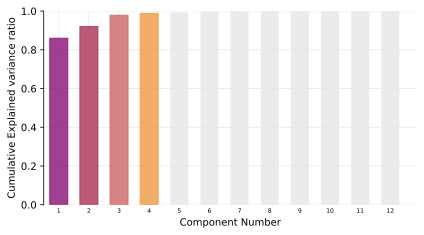

In [9]:
ax = plot_explained(pca.explained_variance_ratio_, 
                    colour_before=4, annotate=False)
ax.set_xlim(-0.5, 13)
ax.grid(True, alpha=0.3)


## Animate Components

To visualise what the components look like, we can animate their effect on the leg. To make the animation clearer, we will apply each component to every leg simultaneously. This is not recreating true spider movement, but it allows us to see what the effect of each component on each leg looks like. 

In [10]:
spider3d = Spider3D(Path("../data/mean_spider_shape_carolina.csv"))

colourList = ['#817', '#a35', '#c66', 
              '#e94', '#ed0', '#9d5', 
              '#4d8', '#2cb', '#0bc',
              '#09c', '#36b', '#639']


score_frames = get_score_range(scores, num_frames=25)
print(score_frames.shape)

for ii in [2]: # Change the component number to view a different component
    spider3d.reset_transformation()
    spider3d.restore_keypoints_to_average()
    
    component_number = [ii]

    reconstructed_frames = reconstruct(score_frames, principal_components, mu, component_number)


    # Then transform the leg agnostic back to the original spider shape (unreflect, remove coxa origin)
    restored_legs = restore_leg_positions(
        reconstructed_frames,
        spider3d,
        all_legs_names
    )


    # Uncomment this to save animations as gifs
    # ani = animate(spider3d, restored_legs, colour = colourList[ii], az=200, el=40) 
    # ani.save(f"../results/gifs/legagnostic/PC0{component_number[0]+1}.gif", writer='Pillow', fps=20, dpi=200)

# View one component interactively
animate_plotly(spider3d, restored_legs, colour = colourList[ii], score_vals=score_frames[:, ii])


(24, 12)


## Scores for Each Leg

We can now see how the legs differ in their scores. We can plot all the scores from all the recordings as a histogram, with each leg in a different colour. Legs are coloured by left (light) and dark (right). 

As we can see, the legs are more or less separated by the first component. As predicted, this shows the leg direction. The front four legs and back four legs are split across the zero line. 

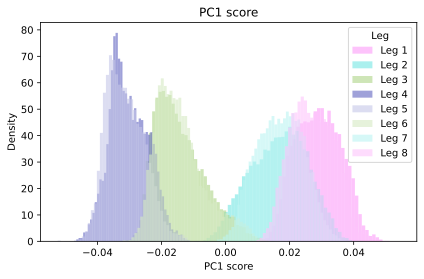

In [17]:
fig, ax = plot_leg_score_hist(reshaped_scores, pc_number=0)


### PC 2

The second component shows the leg spread away from the body. Positive score is constricted, while negative score is spread out. 

While not as separated as the first component, it is still clear that the very front legs and very back legs have the same score and do not show much variation. However, the middle legs have different scores with more variation. 

The front legs and back legs are more constricted overall and do not show much spreading. The middle legs spread more, and the mid back legs change the most in spreading. 



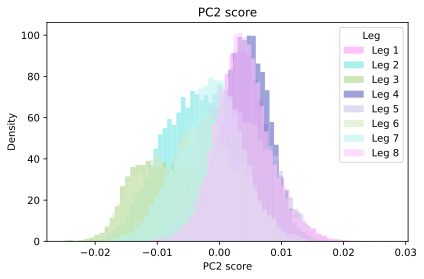

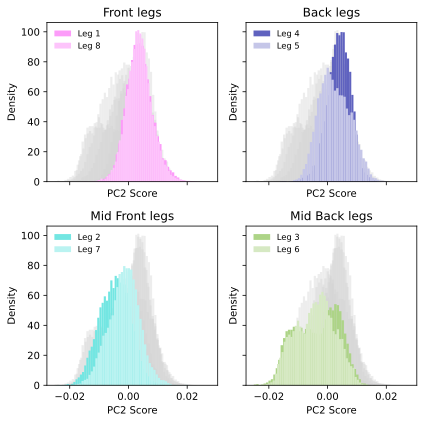

In [18]:
fig, ax = plot_leg_score_hist(reshaped_scores, pc_number=1)

fig, ax = plot_leg_score_hist_panelled(reshaped_scores, pc_number=1)
# ax.set_title("PC 2")


In [19]:
plt.close("all")


## Store Scores in a Dataframe

To compare scores across the different experimental conditions and for individual sequences, we can store the scores in a dataframe with the information from the spider data. 

To do this we make a stacked dataframe with each frame from the data duplicated eight times, showing the PC scores for the eight legs. 

In [20]:
# Stack scores for all legs
all_legs_scores = []
for iLeg in range(8):
    leg_scores_df = create_scores_dataframe(
        reshaped_scores[:, iLeg, :], 
        spider_data_df=carolina_info, 
        time_column="time_in_frames", 
        filename_column="filename", 
        sq_level_column="sq_level", 
        leg_number=iLeg + 1  # Leg numbers start from 1
    )
    all_legs_scores.append(leg_scores_df)

# Concatenate all leg scores into a single DataFrame
all_legs_scores_df = pd.concat(all_legs_scores, ignore_index=True)

# Order by sequenceID and time_in_frames
all_legs_scores_df = all_legs_scores_df.sort_values(by=["sequenceID", "time_in_frames"]).reset_index(drop=True)

all_legs_scores_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.041529  0.006282 -0.013461 -0.002042 -0.000590  0.001099 -0.002425   
1  0.025717 -0.001660 -0.007693 -0.001040  0.002386  0.000392 -0.000540   
2 -0.021983 -0.005953  0.005007 -0.001820  0.000293 -0.000999 -0.000639   
3 -0.016527  0.003527  0.003145  0.002986 -0.000594  0.000091  0.001035   
4 -0.041503  0.005237 -0.000538 -0.003461  0.000682  0.000366  0.000603   

        PC8       PC9  PC10  PC11  PC12 sq_level  \
0 -0.001147  0.000352   0.0   0.0   0.0    sq060   
1  0.001196 -0.000786   0.0   0.0   0.0    sq060   
2  0.000231 -0.000560   0.0   0.0   0.0    sq060   
3  0.000448 -0.000213   0.0   0.0   0.0    sq060   
4 -0.000860 -0.000452   0.0   0.0   0.0    sq060   

                      sequenceID  time_in_frames  leg_number  
0  Y20220113_carolina_3_sq060_01        0.000026           1  
1  Y20220113_carolina_3_sq060_01        0.000026           2  
2  Y20220113_carolina_3_sq060_01        0.000026           3  
3  Y20220113_carolina_3_sq060_01        0.000026           4  
4  Y20220113_carolina_3_sq060_01        0.000026           5

## Experimental Conditions

### PC1: Leg Direction

We can now look at the scores for each experimental condition. In sq100, the spider has an open corridor to walk down, while sq40 is the most constricted. 

As before we can see the legs are separated by the first component score, as we would expect because they point in different directions. Now we have also coloured by experimental conditions, we can also see a difference in sq40 and sq60 compared to the other conditions for legs 3 and 6, the mid back legs. This explains the spread we saw in the previous plot. We also see a small negative outlier peak in sq080, a middle condition, for the back legs. 




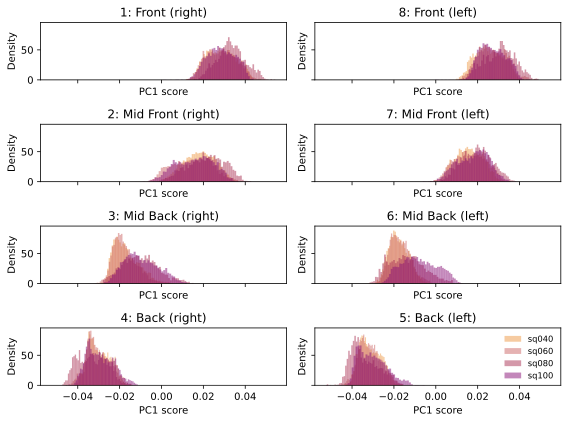

In [34]:

leg_order = [1, 8, 2, 7, 3, 6, 4, 5]
pair_names = ["Front (right)", "Front (left)", 
              "Mid Front (right)", "Mid Front (left)", 
              "Mid Back (right)", "Mid Back (left)", 
              "Back (right)", "Back (left)"]
fig, axes = plt.subplots(4,2,figsize=(8,6), sharex=True, sharey=True)
axes = axes.flatten()
for iLeg, leg_number in enumerate(leg_order):
    plot_pc_histogram(all_legs_scores_df[all_legs_scores_df["leg_number"] == leg_number], 
                      pc_number=1, ax=axes[iLeg])
    axes[iLeg].set_title(f"{leg_number}: {pair_names[iLeg]}")

axes[-1].legend(frameon=False, fontsize="small")
# plot_pc_histogram(scores_df_dict["leg_3"], pc_number=2, ax=axes[0,0])


### PC2: Leg Spread

Here we see a clearer pattern in scores for the experimental conditions. This is also what we found from the whole spider shape PCA, which showed the narrower corridors led to more constricted leg spread. As we have treated the legs separately here we can see which legs are changing their spread the most. 

The least spread is in the very front legs. The middle four legs show more variation, with a different score peak for each experimental condition. Interestingly, while the very back legs are mostly the same scores for different conditions, the exception is in the most restricted corridor for the back left leg. 

Statistical analysis would be required to test significance of these differences. 

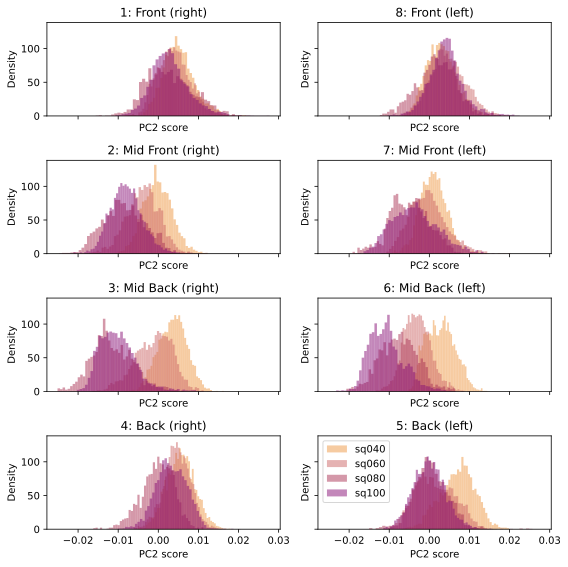

In [33]:

fig, axes = plt.subplots(4,2,figsize=(8,8), sharex=True, sharey=True)
axes = axes.flatten()
for iLeg, leg_number in enumerate(leg_order):
    plot_pc_histogram(all_legs_scores_df[all_legs_scores_df["leg_number"] == leg_number], pc_number=2, ax=axes[iLeg])
    axes[iLeg].set_title(f"{leg_number}: {pair_names[iLeg]}")


axes[-1].legend()

### PC3: Leg Lifting

Positive score is leg lifting, negative score is leg lowering. 

The differences in leg lifting score is far more subtle and does not look significant. However, when splitting by experimental conditions, we can see the front four legs are lowered more and the back legs are a little more raised than other conditions. The variation is also far smaller in this condition. 



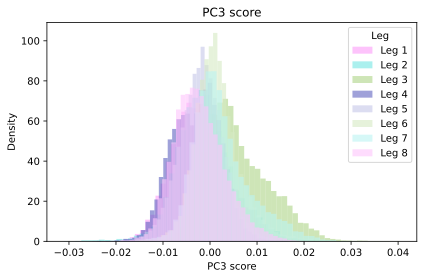

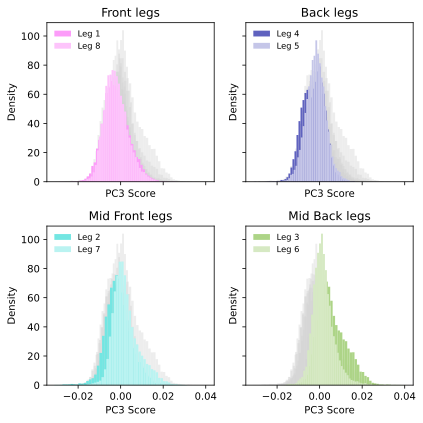

In [23]:
fig, ax = plot_leg_score_hist(reshaped_scores, pc_number=2)

fig, ax = plot_leg_score_hist_panelled(reshaped_scores, pc_number=2)


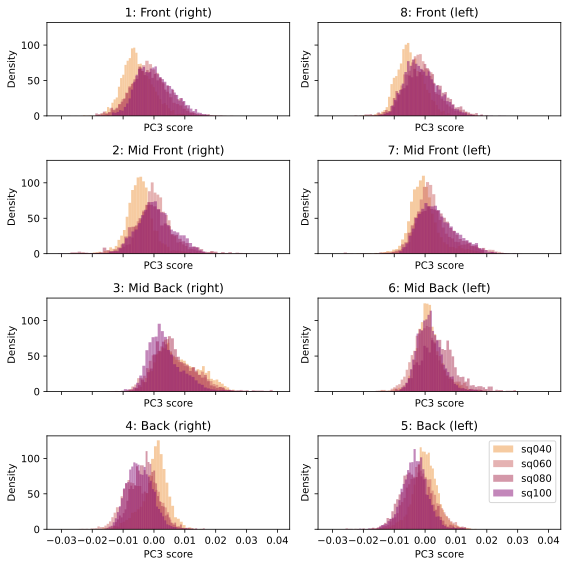

In [32]:

fig, axes = plt.subplots(4,2,figsize=(8,8), sharex=True, sharey=True)
axes = axes.flatten()
for iLeg, leg_number in enumerate(leg_order):
    plot_pc_histogram(all_legs_scores_df[all_legs_scores_df["leg_number"] == leg_number], pc_number=3, ax=axes[iLeg])
    axes[iLeg].set_title(f"{leg_number}: {pair_names[iLeg]}")

axes[-1].legend()

## Score Over Time

To test how the scores vary over time, we can plot the scores for a single sequence and look at the different legs. 

### PC1: Leg Direction

We can first look at the first component. While each leg has a different mean, which corresponds to the overall leg direction anatomically, we can see it also cyclically changes over time. The leg pairings are coloured, where the very back legs are blue (left is light, right is dark). The back legs are in an out of phase motion, which corresponds to a walking gait. The front legs are also out of phase with each other, but not on the same timing as the back legs. The middle legs are closer to in phase, but show independence and variation. These recordings are sensitive to measurement noise. 



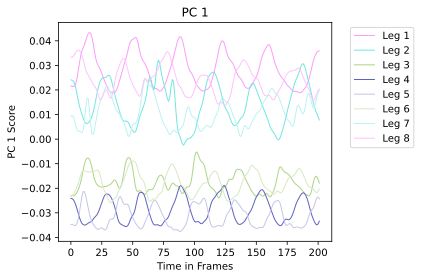

In [26]:
seq = "Y20230605_carolina_3_sq060_1"
fig, ax = plot_leg_pc_timeseries(all_legs_scores_df, 
                                 components_list=[1],
                                 sequence_id=seq, figsize=(6,4))
plt.show()



### Other PCs

We can quickly look at the other components to see how they change over time. 

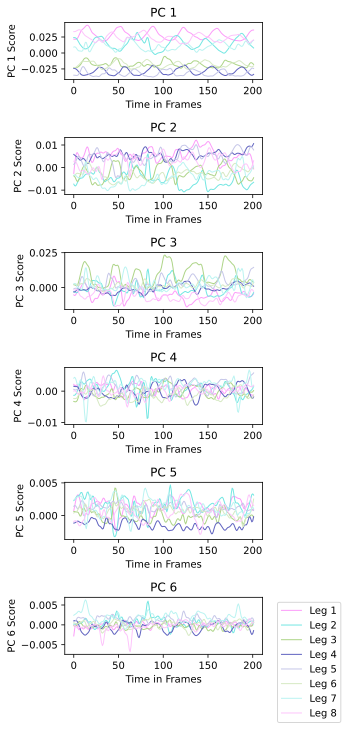

In [27]:
seq = "Y20230605_carolina_3_sq060_1"
fig, ax = plot_leg_pc_timeseries(all_legs_scores_df, 
                                 components_list=[1,2,3,4,5,6], 
                                 leg_list= [1,2,3,4,5,6,7,8],
                                 sequence_id=seq, figsize=(5,10))
plt.show()

## Plotting different components by leg

We can also plot the different PC scores by leg. 

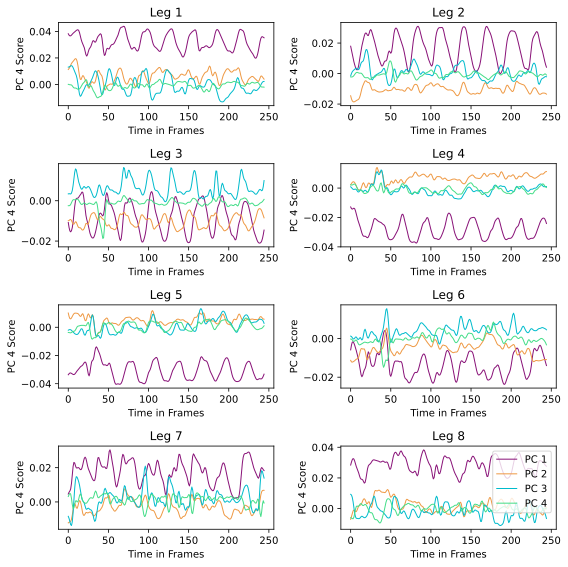

In [28]:
seq = "Y20230116_carolina_3_sq100_01"
colourList = ['#817', '#e94', '#0bc', '#4d8']
currentSeq = all_legs_scores_df[all_legs_scores_df["sequenceID"] == seq]

fig, ax = plt.subplots(4,2,figsize=(8,8))
ax = ax.flatten()
# Plot each leg score over time as a scatter plot with a line connecting the points
for iLeg in range(8):
    for iPC in range(4):
        currentLeg = currentSeq[currentSeq["leg_number"] == iLeg+1]
        ax[iLeg].plot(currentLeg["time_in_frames"], currentLeg[f"PC{iPC+1}"], label=f"PC {iPC+1}", linewidth=1, color=colourList[iPC])
        ax[iLeg].set_title(f"Leg {iLeg+1}")
        ax[iLeg].set_xlabel("Time in Frames")
        ax[iLeg].set_ylabel(f"PC {iPC+1} Score")
ax[iLeg].legend()
plt.tight_layout()
plt.legend()
plt.show()